In [1]:
#analyze dipole statistics over trials
import scipy
import mne
import os
from prediction_utils import *
import pandas as pd
import numpy as np
responses = ['n15','p30','n45','p60']
response_lists = []
sites = ['Tuebingen','Aalto']
source_path_base =r"D:\REFTEP_ALL\Source_analysis"
gof_thresh_average = 75
amplitude_thresh_average = 20*1e-9

In [2]:
#analyze single trial stability
usedsubs = []
response_data = {r:{} for r in responses + ['mep']}
ave_response_data = {r:{} for r in responses + ['mep']}
for response_ind, response in enumerate(responses + ['mep']):
    if response != "mep":
        all_amplitudes = []
        good_subjects_this_response = []
        amplitudes_all = []
        amplitudes_all_stds = []
        amplitudes_all_ptps = []
        amplitudes_all_ptps_stds = []
        amplitudes_eegdata_ptps = []
        amplitudes_eegdata_ptps_stds = []
        dipole_sensor_means = []
        dipole_sensor_stds = []
        gofs_all = []
        gofs_all_stds = []
        amplitudes_all_ave = []
        gofs_all_ave = []
        oris_all_ave = []
        positions_all_ave = []
        times_all = []
        times_all_stds = []
        times_all_ave = []
        ptps_all_ave = []
        window_size_all_ave = []
        times_all_ave_pot = []
        ptp_diffs = []
        ptp_diffs_stds = []
        idx = 0
        for site in sites:
            source_path_site = os.path.join(source_path_base,f'Source_analysis_{site}')
            subjects_dir = fr"D:\REFTEP_ALL\REFTEP_reco\{site}_recon_all/"
            for subject in os.listdir(source_path_site):
                gofs, gof_average, amplitudes, amplitude_average, oris, ori_average, times, time_average, pos, dipole_name, all_dipoles, dipole_average = load_dipole_stats_subject(source_path_site, subject, response)
                #only use data from these subjects in this response
                amplitudes = np.abs(amplitudes)
                if gof_average >= gof_thresh_average and amplitude_average >= amplitude_thresh_average:
                    trans = mne.read_trans(os.path.join(source_path_site,f'{subject}\{subject}_coreg\{subject}-trans.fif'),verbose=False)
                    forward = mne.read_forward_solution(os.path.join(source_path_site,f'{subject}\{subject}-fwd.fif'),verbose=False)
                    leadfield = forward['sol']['data'] - np.mean(forward['sol']['data'],axis=0) #average reference the leadfield
                    start_of_triplet_ind = int(dipole_name.split("_")[-1])*3
                    leadfield_source = leadfield[:,start_of_triplet_ind:start_of_triplet_ind+3]
                    fitting_times = np.load(os.path.join(source_path_site,f'{subject}\{subject}_dipoles\{subject}_dipole_{response}_fitting_times.npy'))
                    time_win_width = (np.max(fitting_times) - np.min(fitting_times))*1000 #fitting time in ms
                    good_subjects_this_response.append(idx)
                    all_amplitudes.append(amplitudes)
                    amplitudes_all.append(np.mean(amplitudes))
                    amplitudes_all_stds.append(np.std(amplitudes))

                    mean_ori = np.mean(oris,axis=0) #mean orientation across all trials
                    #diff_angles = []
                    ptps = []
                    ptps_data_eeg = []
                    diffs_ptps = []
                    epochs = mne.read_epochs(os.path.join(source_path_site,f'{subject}',f'{subject}_final_eeg_post-epo.fif'),verbose=False, proj=False)
                    epochs_data = epochs.get_data(copy=True) #load the epochs data into a separate structure
                    n_trials = epochs_data.shape[0] #number of trials
                    for trial, timenow, ori, amplitude in zip(range(n_trials), times, oris,amplitudes): #calculate the difference in orientation (angles) between mean ori and all orientations
                        stc_now = ori * amplitude
                        dipole_in_sensor = np.matmul(leadfield_source,stc_now)
                        ptp = np.max(dipole_in_sensor)-np.min(dipole_in_sensor)
                        ptps.append(ptp)
                        evoked_trial = mne.EvokedArray(data=epochs_data[trial,:,:], info=epochs.info, tmin=epochs.times[0],nave=1, kind='single_epoch',verbose=False)
                        evoked_trial_data = evoked_trial.crop(timenow, timenow).data[:,0]
                        ptp_eeg = np.max(evoked_trial_data)-np.min(evoked_trial_data)
                        ptps_data_eeg.append(ptp_eeg)
                        diffs_ptps.append(np.abs(ptp_eeg - ptp))

                    amplitudes_all_ptps.append(np.mean(ptps))
                    amplitudes_all_ptps_stds.append(np.std(ptps))

                    amplitudes_eegdata_ptps.append(np.mean(ptps_data_eeg))
                    amplitudes_eegdata_ptps_stds.append(np.std(ptps_data_eeg))

                    gofs_all.append(np.mean(gofs))
                    gofs_all_stds.append(np.std(gofs))

                    times_all.append(np.mean(times))
                    times_all_stds.append(np.std(times))

                    ptp_diffs.append(np.mean(diffs_ptps))
                    ptp_diffs_stds.append(np.std(diffs_ptps))

                    #forward model the dipole back to sensor space
                    stc_now = ori_average * amplitude_average
                    dipole_in_sensor = np.matmul(leadfield_source,stc_now)
                    ptp = (np.max(dipole_in_sensor)-np.min(dipole_in_sensor))
                    ptps_all_ave.append(ptp)
                    
                    window_size_all_ave.append(time_win_width)
                    times_all_ave_pot.append(fitting_times)
                    #print("ptp",ptp)

                    #save info on fitting to the average response
                    amplitudes_all_ave.append(amplitude_average)
                    gofs_all_ave.append(gof_average)
                    oris_all_ave.append(ori_average)
                    pos_in_mni = mne.head_to_mni(pos, subject[0:7] + "_reco", trans, subjects_dir=subjects_dir)
                    positions_all_ave.append(pos_in_mni)
                    times_all_ave.append(time_average)
                    usedsubs.append(subject)
                    #mne.viz.plot_dipole_locations(dipole_average,trans=trans,subject=subject[0:7] + "_reco", subjects_dir=subjects_dir)
                    #mne.viz.plot_dipole_locations(all_dipoles[0],trans=trans,subject=subject[0:7] + "_reco", subjects_dir=subjects_dir)
                        #also load emg responses
    if response != "mep":
        n_subs = len(good_subjects_this_response)
        sqrt_n_subs = np.sqrt(n_subs)
        print(response, n_subs)

        response_data[response]['$R^{2}$ mean ($\%$)'] = str(round(np.mean(gofs_all),1)) + ' ± ' + str(round(np.std(gofs_all),1))
        response_data[response]['$R^{2}$ STD ($\%$)'] = str(round(np.mean(gofs_all_stds),1)) + ' ± ' + str(round(np.std(gofs_all_stds),1))

        response_data[response]['Amplitude mean (nAm)'] = str(round(np.mean(amplitudes_all)*1e9,1)) + ' ± ' + str(round(np.std(amplitudes_all)*1e9,1))
        response_data[response]['Amplitude STD (nAm)'] = str(round(np.mean(amplitudes_all_stds)*1e9,1)) + ' ± ' + str(round(np.std(amplitudes_all_stds)*1e9,1))

        response_data[response]['Dipole PTP mean ($\mu$V)'] = str(round(np.mean(amplitudes_all_ptps)*1e6,1)) + ' ± ' + str(round(np.std(amplitudes_all_ptps)*1e6,1))
        response_data[response]['Dipole PTP STD ($\mu$V)'] = str(round(np.mean(amplitudes_all_ptps_stds)*1e6,1)) + ' ± ' + str(round(np.std(amplitudes_all_ptps_stds)*1e6,1))

        response_data[response]['PTP data mean ($\mu$V)'] = str(round(np.mean(amplitudes_eegdata_ptps)*1e6,1)) + ' ± ' + str(round(np.std(amplitudes_eegdata_ptps)*1e6,1))
        response_data[response]['PTP data STD ($\mu$V)'] = str(round(np.mean(amplitudes_eegdata_ptps_stds)*1e6,1)) + ' ± ' + str(round(np.std(amplitudes_eegdata_ptps_stds)*1e6,1))

        response_data[response]['$\Delta$PTP mean ($\mu$V)'] = str(round(np.mean(ptp_diffs)*1e6,1)) + ' ± ' + str(round(np.std(ptp_diffs)*1e6,1))
        response_data[response]['$\Delta$PTP STD ($\mu$V)'] = str(round(np.mean(ptp_diffs_stds)*1e6,1)) + ' ± ' + str(round(np.std(ptp_diffs_stds)*1e6,1))

        response_data[response]['Latency mean (ms)'] = str(round(np.mean(times_all)*1e3,1)) + ' ± ' + str(round(np.std(times_all)*1e3,1))
        response_data[response]['Latency STD (ms)'] = str(round(np.mean(times_all_stds)*1e3,1)) + ' ± ' + str(round(np.std(times_all_stds)*1e3,1))
        response_data[response]['Window size (ms)'] = str(round(np.mean(window_size_all_ave),1)) + ' ± ' + str(round(np.std(window_size_all_ave),1))

        ave_response_data[response]['$R^{2}$ ($\%$)'] = str(round(np.mean(gofs_all_ave),1)) + ' ± ' + str(round(np.std(gofs_all_ave),1))
        ave_response_data[response]['Amplitude (nAm)'] = str(round(np.mean(amplitudes_all_ave)*1e9,1)) + ' ± ' + str(round(np.std(amplitudes_all_ave)*1e9,1))
        ave_response_data[response]['Peak-to-peak ($\mu$V)'] = str(round(np.mean(ptps_all_ave)*1e6,1)) + ' ± ' + str(round(np.std(ptps_all_ave)*1e6,1))
        ave_response_data[response]['Latency (ms)'] = str(round(np.mean(times_all_ave)*1e3,1)) + ' ± ' + str(round(np.std(times_all_ave)*1e3,1))
        ave_response_data[response]['Window size (ms)'] = str(round(np.mean(window_size_all_ave),1)) + ' ± ' + str(round(np.std(window_size_all_ave),1))
        times_all_ave_pot_ravel = [time for sublist in times_all_ave_pot for time in sublist]
        ave_response_data[response]['Max window limits (ms)'] = str(round(np.min(times_all_ave_pot_ravel)*1e3,1)) + '--' + str(round(np.max(times_all_ave_pot_ravel)*1e3,1))
        for ind, dim in enumerate(['x','y','z']):
            ave_response_data[response][f'loc {dim}'] = str(round(np.mean(positions_all_ave,axis=0)[ind],1)) + ' ± ' + str(round(np.std(positions_all_ave,axis=0)[ind],1))
        for ind, dim in enumerate(['x','y','z']):
            ave_response_data[response][f'ori {dim}'] = str(round(np.mean(oris_all_ave,axis=0)[ind]*100,1)) + ' ± ' + str(round(np.std(oris_all_ave,axis=0)[ind]*100,1))
    else:
        response_data[response]['$R^{2}$ mean ($\%$)'] = " - "
        response_data[response]['$R^{2}$ STD ($\%$)']  = " - "

        response_data[response]['Amplitude mean (nAm)'] = " - "
        response_data[response]['Amplitude STD (nAm)'] = " - "

        response_data[response]['Dipole PTP mean ($\mu$V)'] =" - "
        response_data[response]['Dipole PTP STD ($\mu$V)'] = " - "

        response_data[response]['PTP data mean ($\mu$V)'] = " - "
        response_data[response]['PTP data STD ($\mu$V)'] = " - "

        response_data[response]['$\Delta$PTP mean ($\mu$V)'] = " - "
        response_data[response]['$\Delta$PTP STD ($\mu$V)'] = " - "

        response_data[response]['Latency mean (ms)'] = " - "
        response_data[response]['Latency STD (ms)'] = " - "
        response_data[response]['Window size (ms)'] = "30"

        ave_response_data[response]['$R^{2}$ ($\%$)'] = " - "
        ave_response_data[response]['Amplitude (nAm)'] = " - "
        ave_response_data[response]['Peak-to-peak ($\mu$V)'] = " - "
        ave_response_data[response]['Latency (ms)'] = " - "
        ave_response_data[response]['Window size (ms)'] = " - "
        ave_response_data[response]['Max window limits (ms)'] = " - "
        for ind, dim in enumerate(['x','y','z']):
            ave_response_data[response][f'loc {dim}'] = " - "
        for ind, dim in enumerate(['x','y','z']):
            ave_response_data[response][f'ori {dim}'] = " - "
    


n15 11
p30 23
n45 41
p60 45


In [3]:
#print out latex tables
df = pd.DataFrame(ave_response_data)
print(df.to_latex())
df2 = pd.DataFrame(response_data)
print(df2.to_latex())

\begin{tabular}{llllll}
\toprule
 & n15 & p30 & n45 & p60 & mep \\
\midrule
$R^{2}$ ($\%$) & 84.4 ± 5.7 & 90.2 ± 6.1 & 88.9 ± 6.4 & 93.0 ± 5.0 &  -  \\
Amplitude (nAm) & 59.4 ± 41.7 & 48.6 ± 35.4 & 73.3 ± 84.4 & 61.3 ± 34.8 &  -  \\
Peak-to-peak ($\mu$V) & 9.0 ± 4.0 & 8.2 ± 5.1 & 10.9 ± 8.1 & 11.1 ± 6.3 &  -  \\
Latency (ms) & 16.4 ± 1.7 & 33.0 ± 3.2 & 45.6 ± 3.0 & 63.5 ± 3.5 &  -  \\
Window size (ms) & 7.7 ± 1.4 & 5.1 ± 1.7 & 7.5 ± 2.3 & 12.2 ± 4.0 &  -  \\
Max window limits (ms) & 12.0--25.0 & 25.0--40.0 & 40.0--55.0 & 55.0--73.0 &  -  \\
loc x & 13.1 ± 19.2 & 5.0 ± 20.0 & -9.1 ± 17.0 & -6.7 ± 16.4 &  -  \\
loc y & -28.4 ± 26.0 & -22.6 ± 21.5 & -15.0 ± 27.7 & -20.3 ± 19.6 &  -  \\
loc z & 26.9 ± 26.8 & 38.7 ± 24.1 & 18.9 ± 26.0 & 31.2 ± 19.7 &  -  \\
ori x & 46.4 ± 32.7 & 2.0 ± 37.6 & -38.5 ± 38.1 & -43.9 ± 35.2 &  -  \\
ori y & 27.6 ± 34.8 & 11.6 ± 44.0 & -35.6 ± 33.5 & -42.4 ± 39.1 &  -  \\
ori z & 38.2 ± 57.9 & 55.7 ± 58.4 & -5.6 ± 68.2 & 0.5 ± 59.2 &  -  \\
\bottomrule
\end{tabul

In [4]:
#analyze tep-tep and tep-mep correlations across trials and trends in amplitudes
from pymannkendall import original_test
from collections import Counter
import scipy.io
all_responses = responses + ['mep']
amps = {r:[] for r in all_responses}
gofs_all = {r:[] for r in all_responses}
good_subjects_this_response = {r:[] for r in all_responses}
latencies_all = []
coil_ori_diffs = []
coil_pos_diffs = []
coil_normal_diffs = []
coil_good_inds_notnans = []
good_subs_coil = []
for response_ind, response in enumerate(all_responses):
    all_amplitudes = []
    all_amps_means = []
    all_amps_stds = []
    idx = 0
    significants_amp = 0
    slopes_amp  = []
    trends_amp  = []
    significants_gof = 0
    slopes_gof = []
    trends_gof = []
    matching_rates = {r:[] for r in all_responses if r != "mep"} #for storing matching rates
    for site in sites:
        source_path_site = os.path.join(source_path_base,f'Source_analysis_{site}')
        for subject in os.listdir(source_path_site):
            #get stimulation latencies
            if response != 'mep':
                gofs, gof_average, amplitudes, amplitude_average, oris, ori_average, times, time_average, pos, dipole_name, all_dipoles, dipole_average = load_dipole_stats_subject(source_path_site, subject, response)
                #only use data from these subjects in this response
                gofs = np.array(gofs)
                mean_ori = np.mean(oris,axis=0) #mean orientation across all trials
                if gof_average >= gof_thresh_average and amplitude_average >= amplitude_thresh_average:
                    good_subjects_this_response[response].append(idx)
                    #print(response, len(np.array(amplitudes)[np.array(amplitudes)<0]))
                    all_amplitudes.append(amplitudes)

                    trial_directories = os.path.join(source_path_site, subject,f'{subject}_dipoles',f'{subject}_dipole_{response}_trials_all_dipoles')
                    mrates = []
                    for trial_ind, trial_dir in enumerate(os.listdir(trial_directories)):
                        best_dipole_this_trial = mne.read_dipole(os.path.join(source_path_site, subject,f'{subject}_dipoles',f'{subject}_dipole_{response}_trials',f'{subject}_dipole_{response}_trial_{ind}'), verbose=False)
                        trial_dir_path = os.path.join(trial_directories,trial_dir)
                        dipoles_this_trial = [mne.read_dipole(os.path.join(trial_dir_path,filepath), verbose=False) for filepath in os.listdir(trial_dir_path)]
                        other_dipoles = [dipole for dipole in dipoles_this_trial if dipole.times[0] != best_dipole_this_trial.times[0]]
                        if len(dipoles_this_trial) - len(other_dipoles) != 1: #small consistency check
                            raise ValueError("did not find the trial dipole")
                        sign_of_best_dipole = np.sign(best_dipole_this_trial.amplitude[0])
                        signs_of_other_dipoles = np.array([np.sign(dipole.amplitude[0]) for dipole in other_dipoles])
                        n_other_dipoles = len(other_dipoles)
                        matches = np.array(signs_of_other_dipoles == sign_of_best_dipole)
                        mrates.append(np.sum(matches) / n_other_dipoles)
                    matching_rates[response].append(np.mean(mrates))
            else:
                good_subjects_this_response[response].append(idx)
                amplitudes = np.load(os.path.join(source_path_site,subject,f'{subject}_mep_amplitudes.npy'))*1e6
                all_amplitudes.append(amplitudes)
                all_amps_means.append(np.mean(amplitudes))
                all_amps_stds.append(np.std(amplitudes))
            amps[response].append(amplitudes)
            if response=="mep":
                gofs = np.array([0]) #no gofs for meps
            gofs_all[response].append(gofs)
            if (gof_average >= gof_thresh_average and amplitude_average >= amplitude_thresh_average) or response == 'mep':
                mk_result_general_amp = original_test(amplitudes)
                if mk_result_general_amp.p < 0.05:
                    significants_amp  +=1
                    trends_amp.append(mk_result_general_amp.trend)
                    slopes_amp.append(mk_result_general_amp.slope)
                if response != "mep":
                    mk_result_general_gof = original_test(gofs)
                    if mk_result_general_gof.p < 0.05:
                        significants_gof +=1
                        trends_gof.append(mk_result_general_gof.trend)
                        slopes_gof.append(mk_result_general_gof.slope)
            idx += 1
    print(response, significants_amp, Counter(trends_amp), np.mean(np.abs(slopes_amp)), '±', np.std(np.abs(slopes_amp)),'amp')
    if response != "mep":
        print(response, significants_gof, Counter(trends_gof), np.mean(np.abs(slopes_gof))*100,'±',np.std(np.abs(slopes_gof))*100,'gof (percent)')
        print(matching_rates[response])
        print(np.mean(matching_rates[response]))
        print(np.std(matching_rates[response]))
    if response == "mep":
        print('ave amps meps',round(np.mean(all_amps_means),1),'±', round(np.std(all_amps_means),1))
        print('std amps meps',round(np.mean(all_amps_stds),1),'±', round(np.std(all_amps_stds),1))



n15 7 Counter({'increasing': 5, 'decreasing': 2}) 2.895006257932042e-11 ± 2.2735067758694597e-11 amp
n15 7 Counter({'increasing': 4, 'decreasing': 3}) 0.5030184615736545 ± 0.19728378757833923 gof (percent)
[0.7288733513427618, 0.27790731183359096, 0.9899331437792976, 0.97104532839963, 0.9910142348754449, 0.8985739750445634, 0.23929310020680575, 0.7617002309655982, 0.8261904761904763, 0.938217309501411, 0.8454983086130627]
0.7698406155229676
0.25528733072352344
p30 9 Counter({'decreasing': 5, 'increasing': 4}) 1.8704079089050775e-11 ± 9.19759415408737e-12 amp
p30 5 Counter({'decreasing': 3, 'increasing': 2}) 0.704533052849376 ± 0.36030508072562706 gof (percent)
[0.26898770871985156, 0.7544103734208916, 0.9843391902215431, 0.8275166092002354, 0.7466106290672451, 0.9652651858567544, 0.9060886644219976, 0.8356245206206856, 0.8519458544839255, 0.3689522034349621, 0.7182434813248766, 0.6842166979362101, 0.9443946188340807, 0.2798119886264725, 0.934292596894223, 0.8425654363344585, 0.62454545

In [5]:
#perform correlation analysis on meps and teps
from scipy.stats import pearsonr
from scipy.stats import spearmanr
def get_corrs(arr1,arr2,type='spearman'):
    corrs = []
    for a1, a2 in zip(arr1, arr2):
        if type=='pearsonr':
            correlation, p_value = pearsonr(np.log(a1), np.log(a2))
        else:
            correlation, p_value = spearmanr(a1, a2)
        if p_value < 0.05:
            corrs.append(correlation)
    return corrs
#correlation arrays for values and the number of cases
correlations = {r:{} for r in all_responses}
corrnums = {r:{} for r in all_responses}
corrstds = {r:{} for r in all_responses}
#go through all responses
for ind1, response1 in enumerate(all_responses):
    for response2 in all_responses[ind1+1:]: #what subjects are good in both cases
        both_good_subjects_indices = np.intersect1d(good_subjects_this_response[response1],good_subjects_this_response[response2]).astype(int)
        #read amplitudes and store the correlations
        amplitudes1 = []
        amplitudes2 = []
        for ind in both_good_subjects_indices:
            if response1 == "mep" or response2 == "mep":
                if response1 == "mep":
                    amplitudes2.append(np.abs(amps[response2][ind]))
                    amplitudes1.append(amps[response1][ind])
                else:
                    amplitudes1.append(np.abs(amps[response1][ind]))
                    amplitudes2.append(amps[response2][ind])
            else:
                amplitudes1.append(amps[response1][ind])
                amplitudes2.append(amps[response2][ind])
        """print([np.min(a) for a in amplitudes1])
        print([np.max(a) for a in amplitudes1])
        print([np.mean(a) for a in amplitudes1])
        print([np.std(a) for a in amplitudes1])
        print([len(a[a<0])/len(a) for a in amplitudes1])"""
        corrs = get_corrs(amplitudes1,amplitudes2) #TEP-TEP correlations for all subjects
        correlations[response1][response2] = np.mean(corrs) #mean across subjects
        corrstds[response1][response2] = np.std(corrs) #mean across subjects
        corrnums[response1][response2] = len(corrs)/len(amplitudes1) #how many were significant
        print(response1, response2, np.mean(corrs), np.std(corrs), len(corrs))
    #read amplitudes and other dipole metrics and calculate correlations
    amps_now = []
    gofs_now = []
    for index_good in good_subjects_this_response[response1]:
        amps_now.append(amps[response1][index_good])
        if response1!="mep":
            gofs_now.append(gofs_all[response1][index_good])
    if response1 != "mep":
        absamps = [np.abs(amps) for amps in amps_now]
        camps = get_corrs(gofs_now,absamps) #gof-amp correlations
        correlations[response1]['gof_amp_dipole'] = np.mean(camps)
        corrnums[response1]['gof_amp_dipole']=len(camps)/len(amps_now)
        corrstds[response1]['gof_amp_dipole'] = np.std(camps) #std across subjects
        
        print(response1,'gofs and amps',round(np.mean(camps),2), len(camps)/len(gofs_now), np.std(camps), np.min(camps), np.max(camps))
    else: #no dipoles for MEPs
        correlations[response1]['gof_amp_dipole'] = 0
        corrnums[response1]['gof_amp_dipole']=0
        corrstds[response1]['gof_amp_dipole'] = 0
    print("\n")
    

n15 p30 0.32603894922167964 0.5119946565878425 7
n15 n45 -0.29087357720350226 0.14290403057775763 6
n15 p60 -0.2103244506437477 0.10095830995551454 6
n15 mep 0.16064555392110635 0.15280990991567978 6
n15 gofs and amps 0.67 1.0 0.14378979706591868 0.2769414599663284 0.7786268974150378


p30 n45 0.150945430028195 0.470859905407077 17
p30 p60 0.0685524940430043 0.3696537367768856 21
p30 mep 0.1304263013408741 0.07041023944098779 8
p30 gofs and amps 0.72 1.0 0.07246157530145611 0.5632704022446061 0.8444230600716524


n45 p60 0.5847855546020905 0.1659376972072855 41
n45 mep 0.05630491077190576 0.09449953299601402 11
n45 gofs and amps 0.69 1.0 0.07207380120624574 0.528221218442441 0.8382873227565343


p60 mep 0.09964802161542512 0.05313977217138813 21
p60 gofs and amps 0.64 1.0 0.09264159374588338 0.4283843457483036 0.8000766726847385






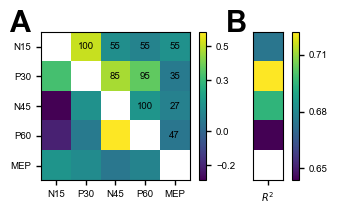

In [6]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['pdf.fonttype'] = 42
#define matrices with correlation coefficients by reading labels from the correlation dictionary
matrix=np.zeros(shape=(5,5))
matrix_numbers = np.zeros(shape=(5,5))
for ind1, response1 in enumerate(all_responses):
    for response2 in all_responses[ind1+1:]:
        ind2 = all_responses.index(response2)
        matrix[ind1,ind2] = correlations[response1][response2]
        matrix[ind2,ind1] = corrstds[response1][response2]
        matrix_numbers[ind1,ind2] = corrnums[response1][response2]
matrix_copy = matrix.copy()
matrix[matrix==0] = np.nan
matrix_numbers[matrix_numbers==0] = np.nan
matrix = np.transpose(matrix)

matrix_gof = np.zeros(shape=(1,5))
for ind1, response1 in enumerate(all_responses):
    matrix_gof[0, ind1] = correlations[response1]['gof_amp_dipole']
matrix_gof_copy = matrix_gof.copy()
matrix_gof[matrix_gof==0] = np.nan
matrix_gof = np.transpose(matrix_gof)

#set up the figure
in_mm_scale = 25.4
fig, axs = plt.subplots(1,2,figsize=(91.5/in_mm_scale,49/in_mm_scale))
image = axs[0].imshow(matrix,cmap='viridis')
image2 = axs[1].imshow(matrix_gof,cmap='viridis')
all_responses_upper = [response.upper() for response in all_responses] #names in upper
#set ticks for the images
axs[0].set_xticks(np.arange(5))
axs[0].set_yticks(np.arange(5))
axs[0].set_yticklabels(all_responses_upper,fontsize=7)
axs[0].set_xticklabels(all_responses_upper,fontsize=7)
axs[1].set_xticks(np.arange(1))
for i in range(len(matrix_numbers)): #display subject percentages
    for j in range(len(matrix_numbers)):
        if str(matrix_numbers[i,j]) != "nan":
            axs[0].text(j,i,f'{round(100*(matrix_numbers[i,j]))}',ha='center',va='center',color='black',fontsize=7)

axs[0].tick_params(width=1)
axs[1].tick_params(width=1)
axs[1].set_xticklabels(["$R^2$"],fontsize=7)

#create colorbars for images
cbar = plt.colorbar(image, ticks=np.round(np.linspace(np.min(matrix_copy),np.max(matrix_copy),6),1))
cbar.ax.tick_params(labelsize=7)
cbar.ax.set_yticks([-0.2, 0, 0.3, 0.5])
#pos = cbar.ax.get_position()
cbar.ax.tick_params(width=1)
cbar = plt.colorbar(image2, ticks=np.round(np.linspace(np.min(matrix_gof_copy),np.max(matrix_gof_copy),10),2))
cbar.ax.tick_params(labelsize=7)
cbar.ax.set_yticks([0.65, 0.68, 0.71])
#pos = cbar.ax.get_position()
cbar.ax.tick_params(width=1)


plt.subplots_adjust(wspace=-0.5)
fig.text(0.04, 0.88, 'A',fontsize=21,fontweight='bold')
fig.text(0.64, 0.88, 'B',fontsize=21,fontweight='bold')
axs[1].set_yticks([])
plt.savefig('correlation_plot_responses9June.pdf',format='pdf',dpi=300)